## Analysis of mappings between nods

In [156]:
import os
from pandas import DataFrame, read_csv, merge, Series, concat

In [157]:
%load_ext autoreload
%autoreload 2

from src.utils import create_folder, clear_folder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
from typing import Dict, List, Union, Set, Tuple

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

## Loading inputs

In [160]:
instance_name: str = 'covert2002-ga100-d0-s0'

rules_folder: str = f'../../_instances/covert2002/{instance_name}/out/regulatory-rules/'

out_dir: str = f'{rules_folder.rsplit("/", maxsplit=2)[0]}/Heatmaps'
clear_folder(out_dir)
create_folder(out_dir)

#Note: you may need to adjust size of the heatmaps and/or the position of their bars.

In [161]:
results_df: Dict[int, DataFrame] = {}
for filename in sorted(os.listdir(rules_folder)):
    filepath: str = rules_folder + filename
    result_id: int = int(filename.split('_')[1].strip('.csv'))
    results_df[result_id] = read_csv(filepath, index_col='node').fillna('')

## Analysis

### Utilitary functions

In [162]:
def format_clause_name(clause: str) -> str:
    formatted_clause: str = clause
    formatted_clause = formatted_clause.replace(' ', '')
    formatted_clause = formatted_clause.replace('&', '+')
    return formatted_clause

In [163]:
def parse_rule(rule:str)->List[str]:
    if '|' in rule:
        rule = rule[1:-1]
    rule_clauses: List[str] = rule.split(' | ')
    return rule_clauses

#### Converge the Dataframes

In [164]:
def converge_dfs(d_df: Dict[str,DataFrame]) -> List[Dict[str, Set[str]]]:
    every_clauses_set: List[Dict[str, Set[str]]] = []
    for i in range(len(d_df)):
        clauses_set : Dict[str, Set[str]] = {} 
        solution : DataFrame = d_df[i]
        for node in solution.index: 
            rules: List[str] = solution.loc[node][solution.loc[node] != ''].to_list() 
            for rule in rules:
                clauses_set.setdefault(node,set()).add(rule)  
        every_clauses_set.append(clauses_set) 
    return every_clauses_set

## New functions

In [165]:
def num_BN_per_rules_X(rules_X: Dict[str, Set[str]]) -> int:
    nb_BN = 1
    for node in rules_X:
        nb_BN *= len(rules_X[node])
    return nb_BN

In [166]:
def num_rules_per_node(ens_rules_node:Set[str]) -> int:
    nb_rules = 0
    for rule in ens_rules_node:
        nb_rules += 1
    return nb_rules
#== len(rules_X[node])

In [167]:
def num_clause_per_node(ens_rules_node:Set[str],clause:str) -> int:
    nb_present = 0
    for rule in ens_rules_node:
        rule_clauses = parse_rule(rule)
        if clause in rule_clauses:
            nb_present += 1
    return nb_present

In [168]:
# def num_map_per_rules_X(rules_X: Dict[str, Set[str]]) -> int:     # unused
#     count: int = 0
#     for node in rules_X:
#         for rule in rules_X[node]:
#             l_clauses: List[str] = parse_rule(rule)
#             l_done: List[str] = []
#             for clause in l_clauses:
#                 if clause != 1 and not(clause in l_done):
#                     count +=1
#                     l_done.append(clause)
#     return count

In [169]:
def num_body_n_head_per_node(ens_rules_node:Set[str],head:str,body:str) -> int:
    nb_present = 0
    for rule in ens_rules_node:
        rule_clauses = parse_rule(rule)
        if (body in rule_clauses) and (head in rule_clauses):
            nb_present +=1
    return nb_present

In [170]:
def per_solution(clauses_set:Dict[str,Set[str]]) -> Tuple[Dict[str,float], Dict[str,Dict[str,float]]]:
    num_of_BN: int = num_BN_per_rules_X(clauses_set)
    head_count: Dict[str,int] = {}
    association: Dict[str,Dict[str,float]] = {}

    for node in clauses_set: # for each node in the solution
        num_of_rules: int = num_rules_per_node(clauses_set[node])
        for rule in clauses_set[node]:  # for each rule of this node
            rule_clauses = parse_rule(rule)
            for clause in rule_clauses:     # for each clause in this rule = it's a "head"

                mapHead: str = f'{node}<-{format_clause_name(clause.strip("(").strip(")"))}'
                countHead: float = num_clause_per_node(clauses_set[node],clause) / num_of_rules * num_of_BN 
                head_count[mapHead] = countHead # get the number of occurence of the head in the BNs
                association[mapHead] = {}
                for node_Bis in clauses_set: # for each node again

                    if node == node_Bis:    # if it's the same node
                        for rule_Bis in clauses_set[node]:
                            rules_clauses_Bis = parse_rule(rule_Bis)    # get the "body(ies)"
                            if clause in rules_clauses_Bis: 
                                for clause_Bis in rules_clauses_Bis:    # if associated with the head   
                                    if clause_Bis != clause:                # and isn't the head
                                        mapBody: str = f'{node}<-{format_clause_name(clause_Bis.strip("(").strip(")"))}'
                                        countBody: float = num_body_n_head_per_node(clauses_set[node],clause,clause_Bis) / num_of_rules * num_of_BN
                                        # count for the node the number of occurence of the head AND the body in the BNs
                                        if mapBody not in association[mapHead]: # if not in yet, add it
                                            association[mapHead][mapBody] = countBody
                                        # need to count it only once, not a count by rule
                    else:   # if not the same node 
                        num_of_rulesBis: int = num_rules_per_node(clauses_set[node_Bis])    
                        for rule_Bis in clauses_set[node_Bis]:
                            rules_clauses_Bis = parse_rule(rule_Bis)
                            for clause_Bis2 in rules_clauses_Bis:
                                mapBody: str = f'{node_Bis}<-{format_clause_name(clause_Bis2.strip("(").strip(")"))}'
                                countBody: float = num_clause_per_node(clauses_set[node_Bis],clause_Bis2) / num_of_rulesBis * countHead
                                
                                if mapBody not in association[mapHead]:
                                        association[mapHead][mapBody] = countBody
                                #need to count it only once, not a count by rule        
    
    return((head_count,association))

In [171]:
def all_solution(every_clauses_set: List[Dict[str, Set[str]]]) -> Tuple[Dict[str,float],Dict[str,Dict[str,float]]] :
    head_count: Dict[str,int] = {}
    association: Dict[str,Dict[str,float]] = {}

    for solution in every_clauses_set:
        sol_head_count,sol_association = per_solution(solution)
        
        for mapHead1 in sol_head_count:
            if mapHead1 not in head_count:
                head_count[mapHead1] = sol_head_count[mapHead1]
            else:
                head_count[mapHead1] = head_count[mapHead1] + sol_head_count[mapHead1]
        
        for mapHead2 in sol_association:
            if mapHead2 not in association:
                association[mapHead2]: Dict[str,float] ={}
                for mapBody in sol_association[mapHead2]:
                    association[mapHead2][mapBody]= sol_association[mapHead2][mapBody]
            else:
                for mapBody in sol_association[mapHead2]:
                    if mapBody not in association[mapHead2]:
                        association[mapHead2][mapBody] = sol_association[mapHead2][mapBody]
                    else:
                        association[mapHead2][mapBody] = association[mapHead2][mapBody] + sol_association[mapHead2][mapBody]

    return((head_count,association))


In [172]:
def solution_to_df(head_count: Dict[str,int],association: Dict[str,Dict[str,float]]) -> DataFrame:
    for mapping1 in association:
        for mapping2 in association:
            if mapping1 != mapping2:
                if mapping2 not in association[mapping1]:
                    association[mapping1][mapping2] = 0.0
    df_matrix: DataFrame = DataFrame.from_dict(association)
    #add the total line
    last = len(df_matrix.index)
    df_matrix.loc[len(df_matrix.index)] = head_count
    df_matrix2 = df_matrix.rename(index={last: 'nb_BN_with_it'})
    return df_matrix2

In [173]:
def freq_matrix(df:DataFrame) -> DataFrame:
    new_df = DataFrame(df)
    for i in range(len(df.index)-1):
        for j in range(len(new_df.columns)):
            new_df.iloc[i, j]= df.iloc[i, j]/df.iloc[len(df.index)-1, j] * 100
    return new_df

## Create a matrix with all the mappingss

In [174]:

every_clauses_set: List[Dict[str, Set[str]]] = converge_dfs(results_df)
h_count,assoc = all_solution(every_clauses_set)
matrix: DataFrame = freq_matrix(solution_to_df(h_count,assoc))
freq_matrix_filename: str = f'{out_dir}/all_freq_matrix.csv'
matrix.to_csv(freq_matrix_filename, sep=',')

[Text(0.5, 113.58159722222219, 'other mappings'),
 Text(158.0815972222222, 0.5, 'Mapping of interest')]

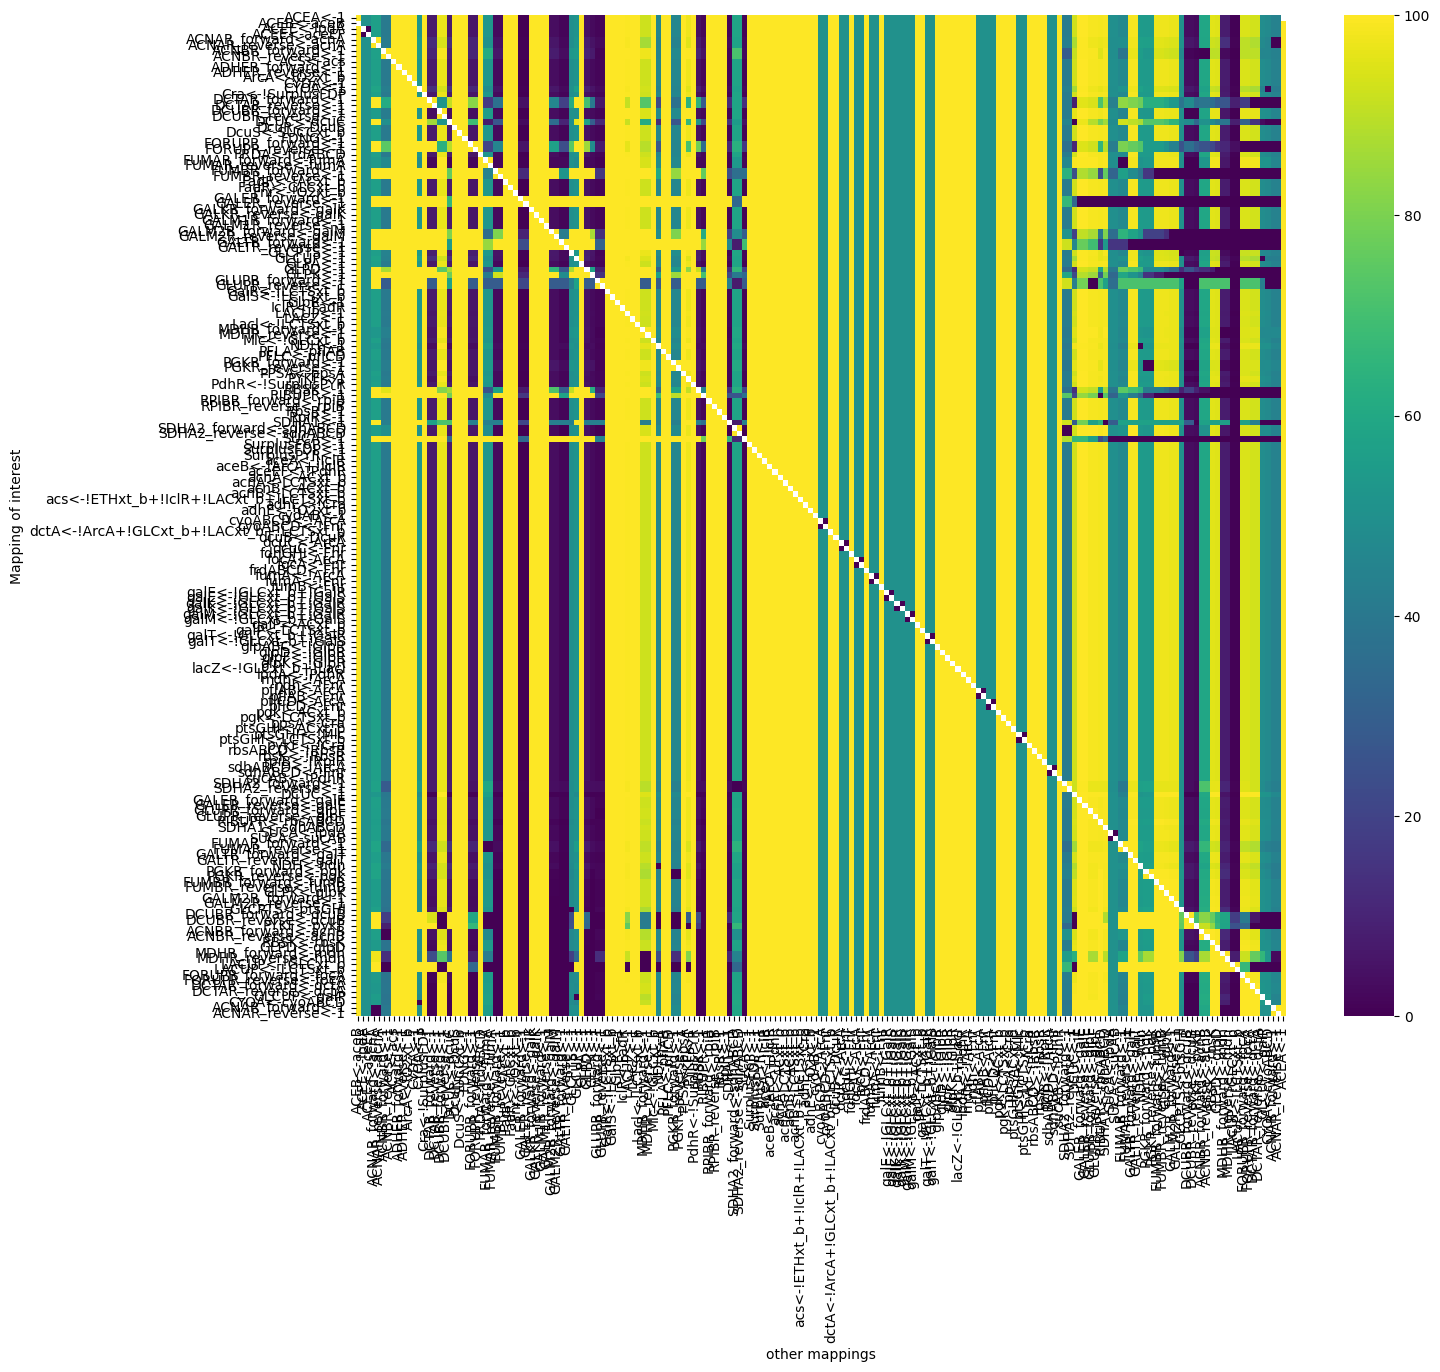

In [175]:
# heatmap with all
hp_matrix_all: DataFrame = DataFrame(columns= matrix.keys())
for i in range(len(matrix.index)):
    if matrix.index[i] in matrix.columns:
        hp_matrix_all= concat([hp_matrix_all,matrix.iloc[[i]]])

hp_matrix_all = hp_matrix_all.transpose()

plt.figure(figsize=(15,13)) #to change the size of the visualization
hp_all = sns.heatmap(hp_matrix_all,cmap = "viridis",  xticklabels=True, yticklabels=True)
hp_all.set(xlabel="other mappings",ylabel="Mapping of interest")

### Functions to Remove the omnipresent mappings

In [176]:
simple_matrix_filename: str = f'{out_dir}/simple_freq_matrix.csv'

In [177]:
def total_BN(every_clauses_set: List[Dict[str, Set[str]]]) -> int:
    total = 0
    for clause_set in every_clauses_set:
        total += num_BN_per_rules_X(clause_set)
    return total

In [178]:
def remove_omni_for_map(matrix: DataFrame, tot_BN: int) -> DataFrame: 
    new_matrix_col: DataFrame = DataFrame()
    l_ubiq= []
    for i in range(len(matrix.columns)):
        col_name = matrix.keys()[i]
        if matrix.iloc[len(matrix.index)-1, i] != tot_BN:
            extracted_col = matrix[col_name]
            new_matrix_col.insert(len(new_matrix_col.columns),col_name,extracted_col)
        else:
            l_ubiq.append(col_name)
    # need to remove from the rows too
    new_matrix_row: DataFrame = DataFrame(columns= new_matrix_col.keys())
    for i in range(len(new_matrix_col.index)):
        if new_matrix_col.index[i] not in l_ubiq: 
            new_matrix_row = concat([new_matrix_row,new_matrix_col.iloc[[i]]])
    #add total count/total BN
    new_matrix_row = concat([new_matrix_row,(new_matrix_col.iloc[[len(new_matrix_col)-1,]]/tot_BN)])
    result = new_matrix_row.set_index(new_matrix_row.index.where(~new_matrix_row.index.duplicated(), 'Percentage of the total number of BN'))
    return result

### Create a matrix without the ubiquitary mappings

In [179]:
tot_BN: int = total_BN(every_clauses_set)
new_matrix: DataFrame = remove_omni_for_map(matrix, tot_BN)
new_matrix.to_csv(simple_matrix_filename, sep=',')

/tmp/ipykernel_126407/402020379.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_matrix_col.insert(len(new_matrix_col.columns),col_name,extracted_col)
/tmp/ipykernel_126407/402020379.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_matrix_col.insert(len(new_matrix_col.columns),col_name,extracted_col)
/tmp/ipykernel_126407/402020379.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

### Heatmap

[Text(0.5, 300.5815972222222, 'other mappings'),
 Text(345.58159722222223, 0.5, 'Mapping of interest')]

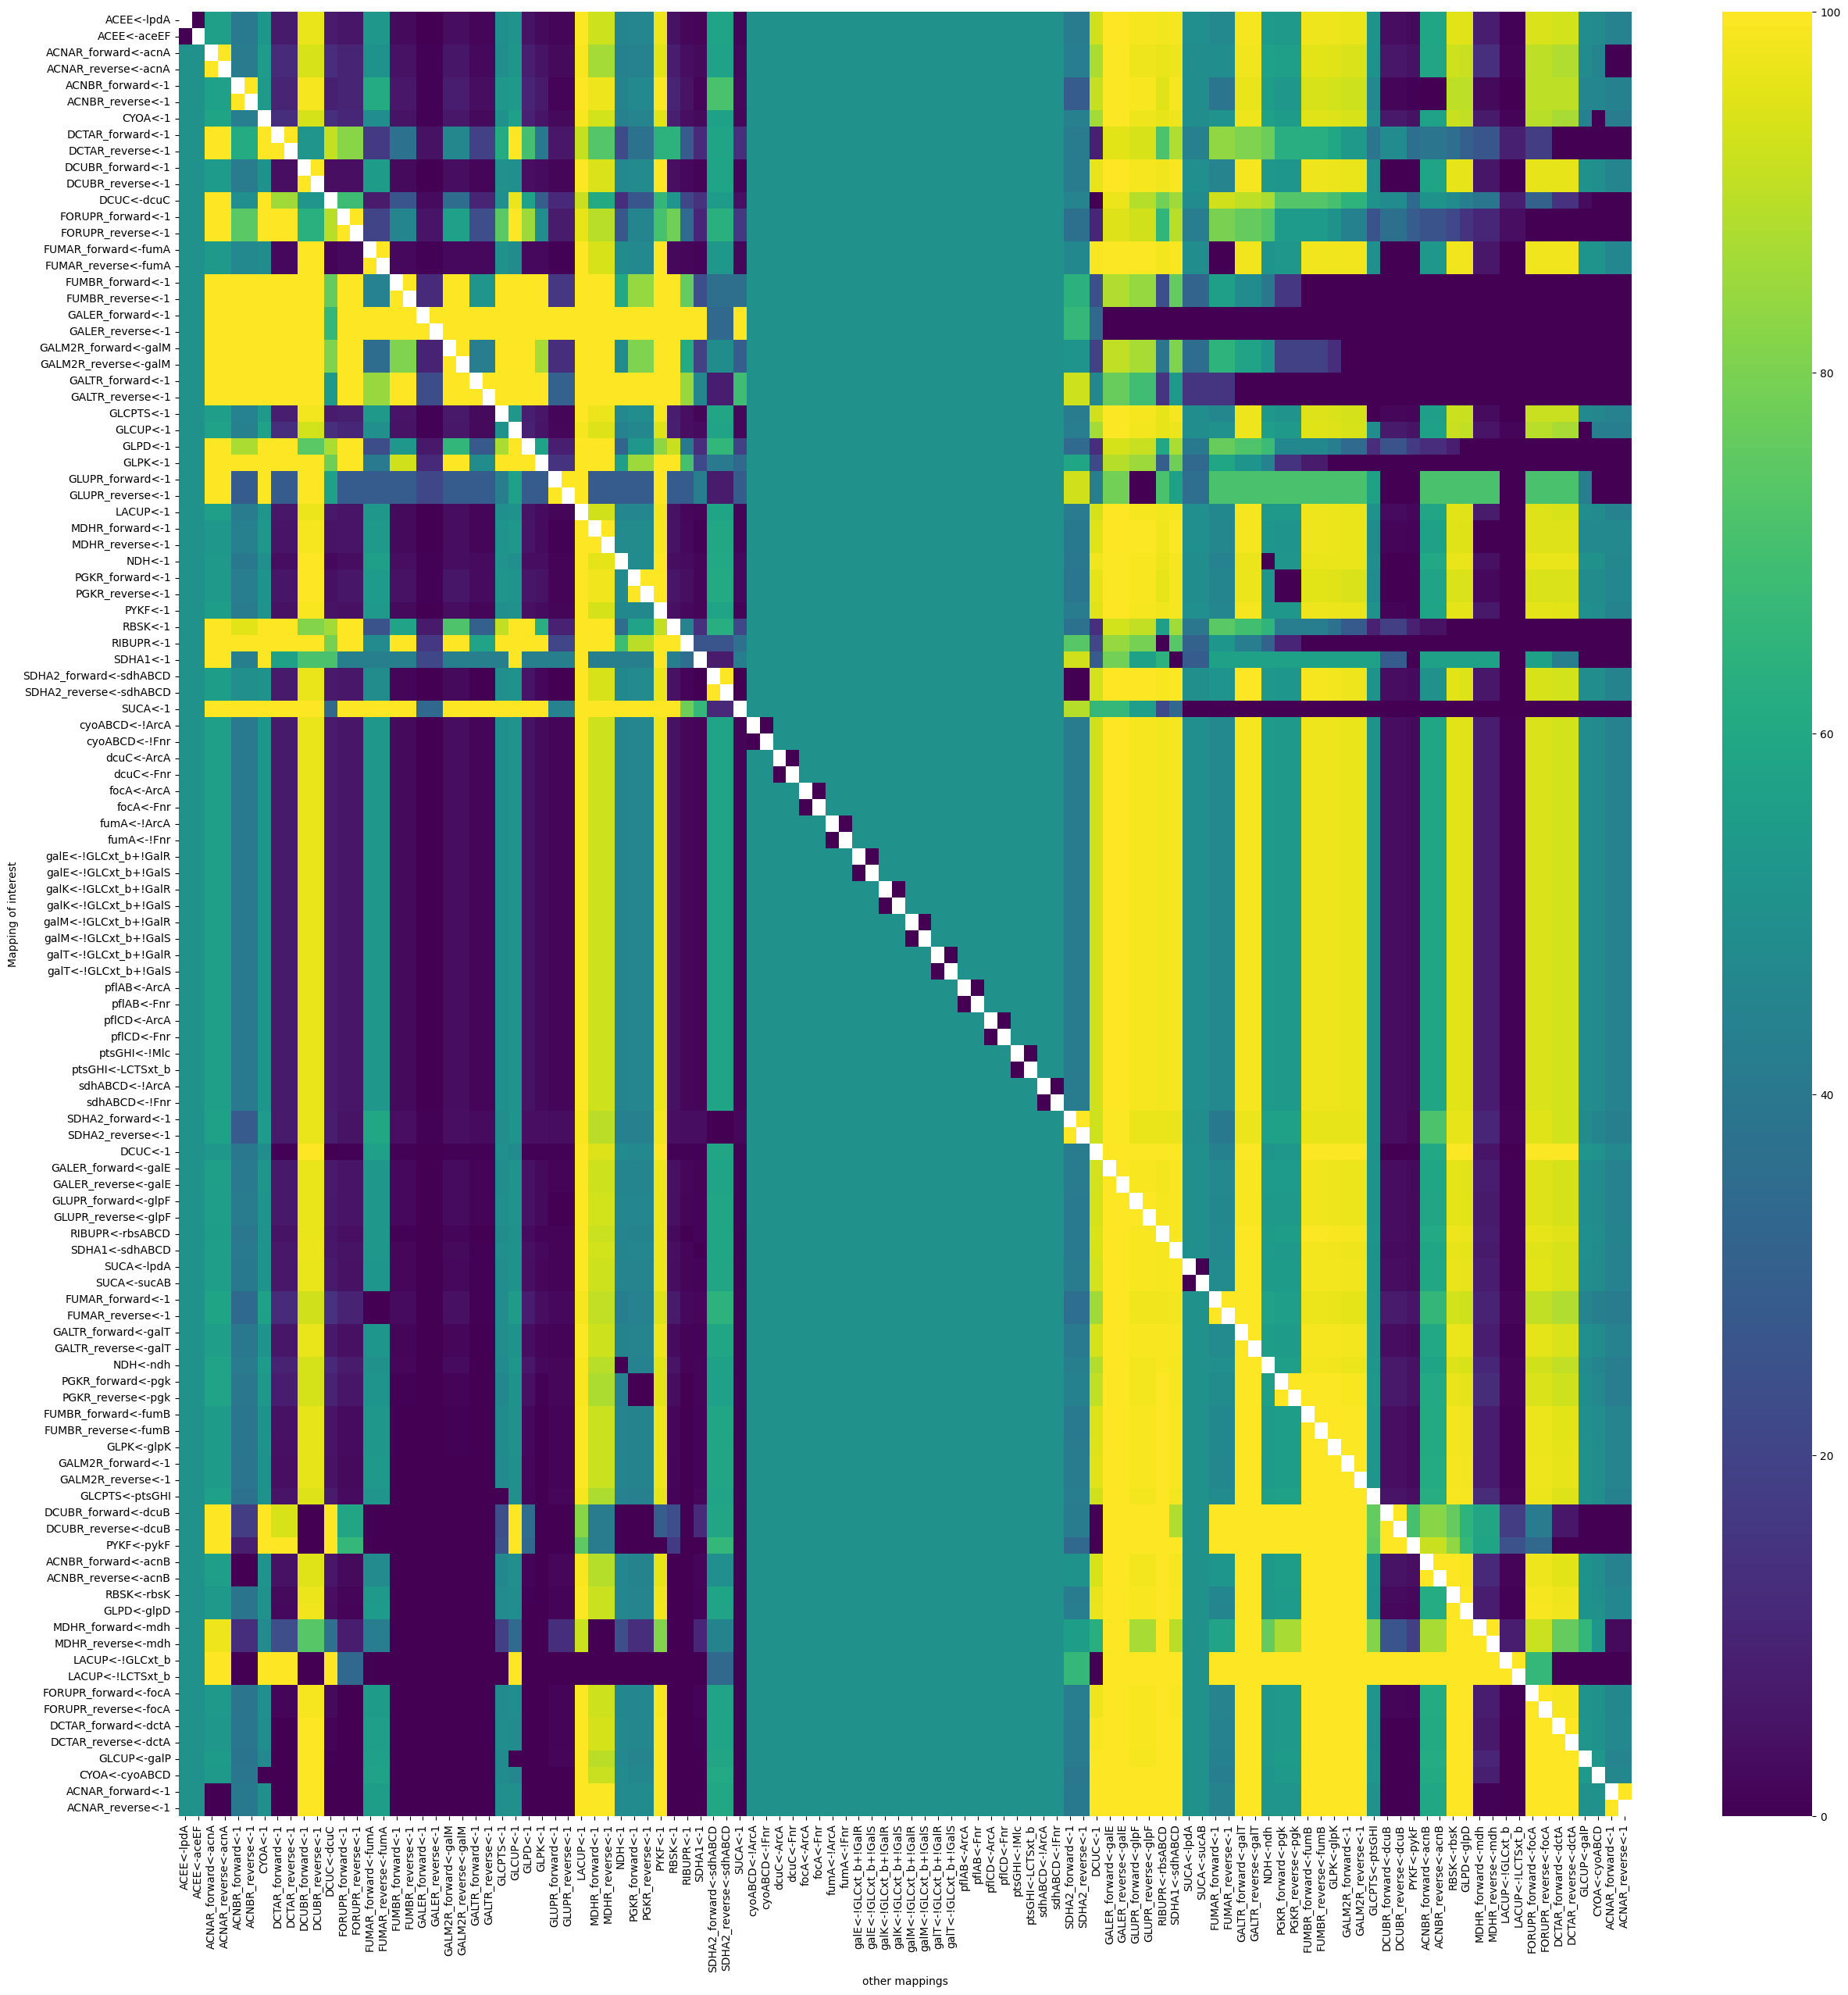

In [180]:
hp_matrix: DataFrame = DataFrame(columns= new_matrix.keys())
for i in range(len(new_matrix.index)):
    if new_matrix.index[i] in new_matrix.columns:
        hp_matrix= concat([hp_matrix,new_matrix.iloc[[i]]])

hp_matrix= hp_matrix.transpose()

plt.figure(figsize=(30,30)) # to adjust the size of the map
#hp = sns.heatmap(hp_matrix,cmap = "viridis", linewidth=.5, xticklabels=True, yticklabels=True, vmax=100) #to add lines between rows and columns
hp = sns.heatmap(hp_matrix,cmap = "viridis",  xticklabels=True, yticklabels=True, vmax=100)
hp.set(xlabel="other mappings",ylabel="Mapping of interest")

### Biclustering hierarchic

/udd/alerever/Documents/Alex/Merrin-internship/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


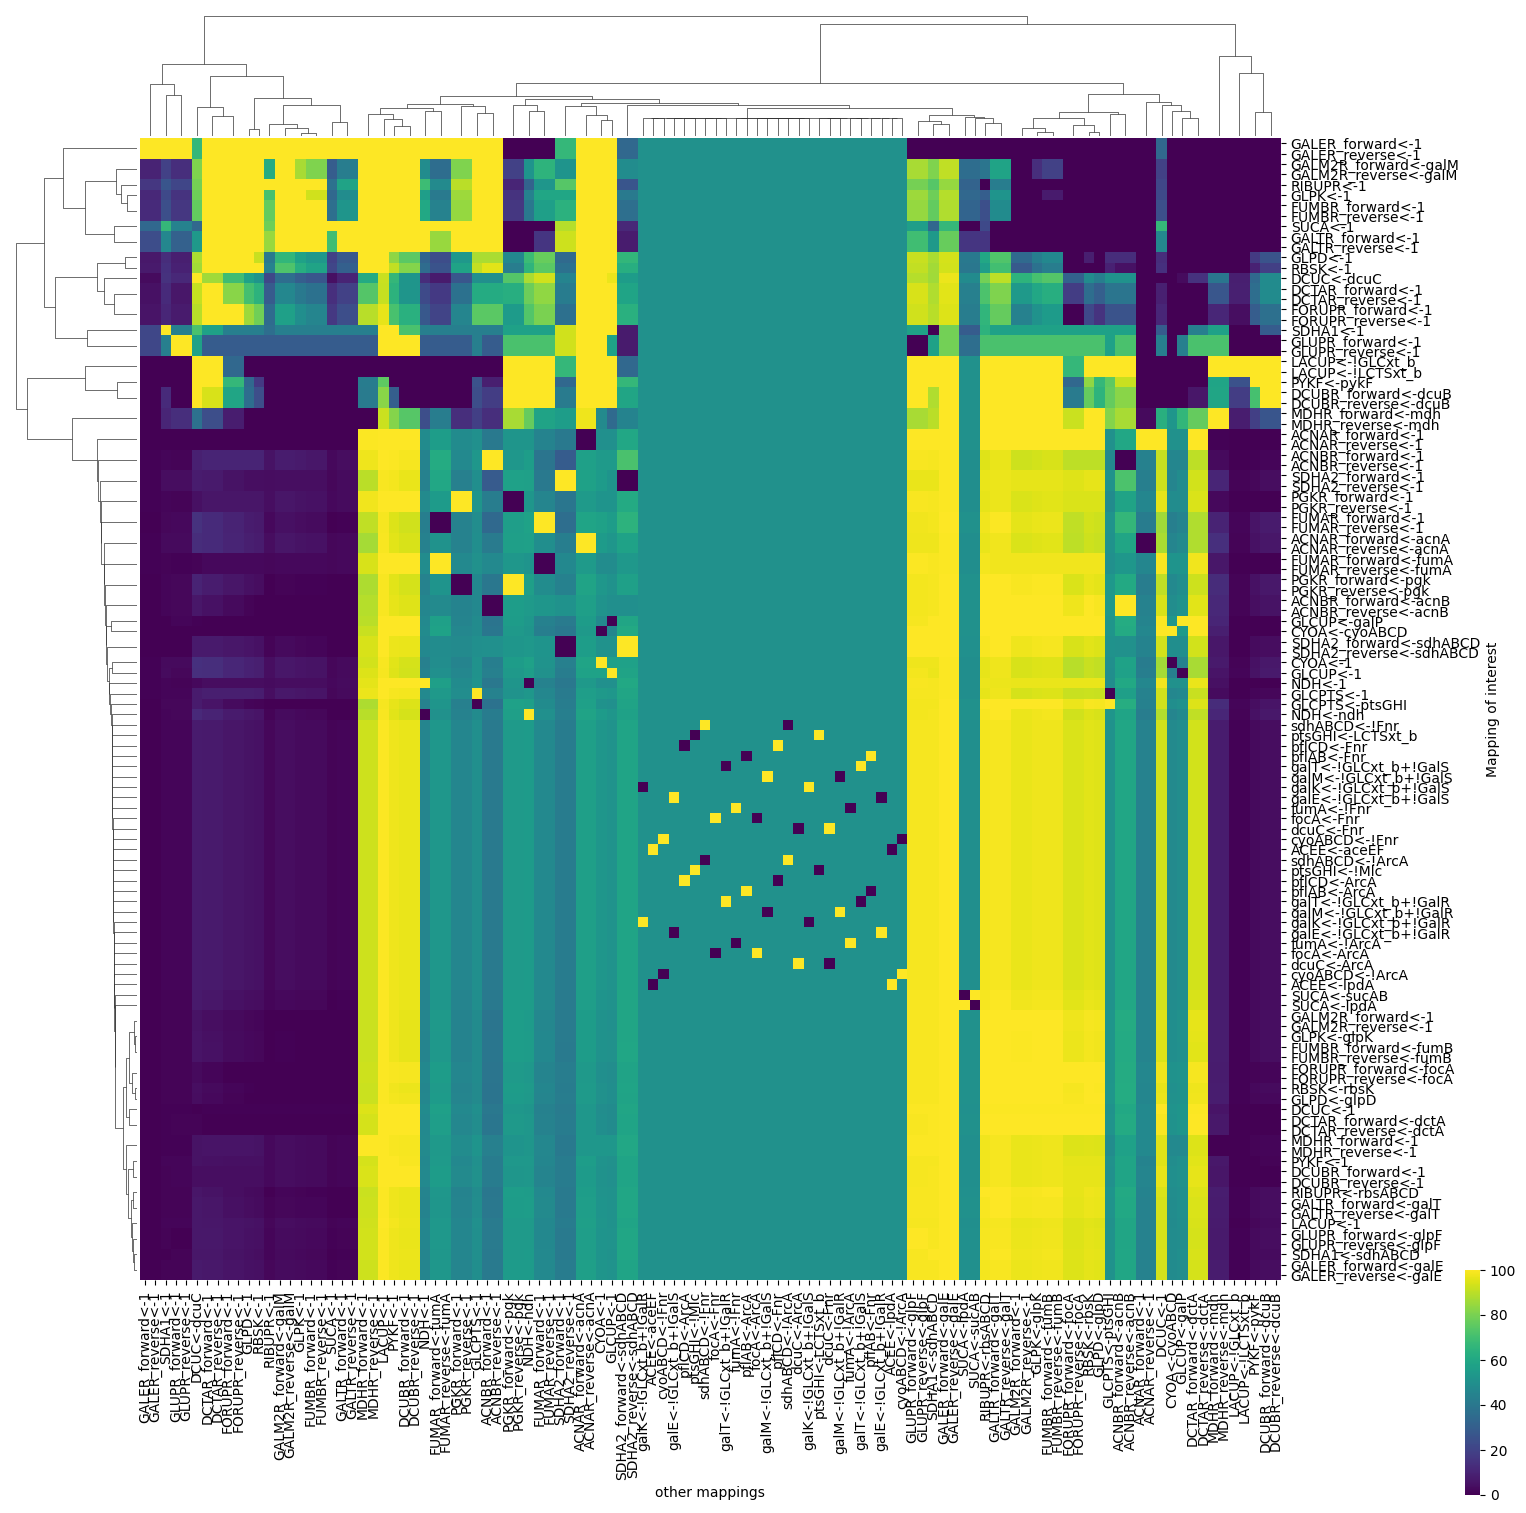

In [181]:
hp_matrix= hp_matrix.fillna(100)
bchp = sns.clustermap(hp_matrix , figsize=(15,15), cmap="viridis", metric="jensenshannon" ,dendrogram_ratio = 0.1, cbar_pos=(0.98,0.0,0.01,0.15),xticklabels=True, yticklabels=True)
ax = bchp.ax_heatmap
ax.set_xlabel("other mappings")
ax.set_ylabel("Mapping of interest")
bchp.savefig(f'{out_dir}/{instance_name}_biclustering_simple.png',format='png')

## Creating a matrix mappings vs node

In [182]:
every_nodes : Dict[str, int] = {}
all_mappings : Set[str] = set()
every_mapping_set: Dict[str,Set[str]]={}

node_vs_mapping : Dict[str,Dict[str,float]] = {}

for i in range(len(every_clauses_set)):
    solution = every_clauses_set[i]
    nb_bn_i = num_BN_per_rules_X(solution)
    every_mapping_set[i]=set()
    for node in solution:
        check = solution[node].copy()
        if len(solution[node]) == 1 and check.pop() == "1": #if not regulated
            pass
        else:   #if regulated
            if node in every_nodes: #if found before
                every_nodes[node] = every_nodes[node] + nb_bn_i
            else:   #if first time
                every_nodes[node] = nb_bn_i
                node_vs_mapping[node]= {}

            for node_bis in solution: #look for each node in the same solution, even itself
                l_done: List[str] = []
                for rule in solution[node_bis]: 
                    l_clauses = parse_rule(rule)
                    
                    for clause in l_clauses: #for each clause in each rule for the node
                        if clause == "1" or (clause in l_done): #if not regulated or clause already found once
                            pass
                        else:
                            if clause[0]=="(":
                                mapping = f'{node_bis}<-{clause[1:-1]}'
                            else:
                                mapping = f'{node_bis}<-{clause}'
                            all_mappings.add(mapping)
                            every_mapping_set[i].add(mapping)
                            l_done.append(clause)
                            nb_occu_map : int = num_clause_per_node(solution[node_bis],clause) / num_rules_per_node(solution[node_bis]) * nb_bn_i
                            if mapping in node_vs_mapping[node]:
                                node_vs_mapping[node][mapping] = node_vs_mapping[node][mapping] + nb_occu_map
                            else:
                                node_vs_mapping[node][mapping] = nb_occu_map

for node in node_vs_mapping:
    for mapping in node_vs_mapping[node]:
        node_vs_mapping[node][mapping] = int(node_vs_mapping[node][mapping] / every_nodes[node] * 100)

node_vs_node_matrix_df: DataFrame = DataFrame(columns = [c for c in all_mappings], index = [c for c in every_nodes])

for node in node_vs_mapping:
    for mapping in node_vs_mapping[node]:
        node_vs_node_matrix_df.at[node,mapping] = node_vs_mapping[node][mapping]
node_vs_node_matrix_df = node_vs_node_matrix_df.fillna(0)

node_matrix_filename: str = f'{out_dir}/node_matrix.csv'
node_vs_node_matrix_df.to_csv(node_matrix_filename, sep=',')   

### Visualisation


[Text(0.5, 190.5815972222222, 'Mappings'),
 Text(220.58159722222223, 0.5, 'Nodes')]

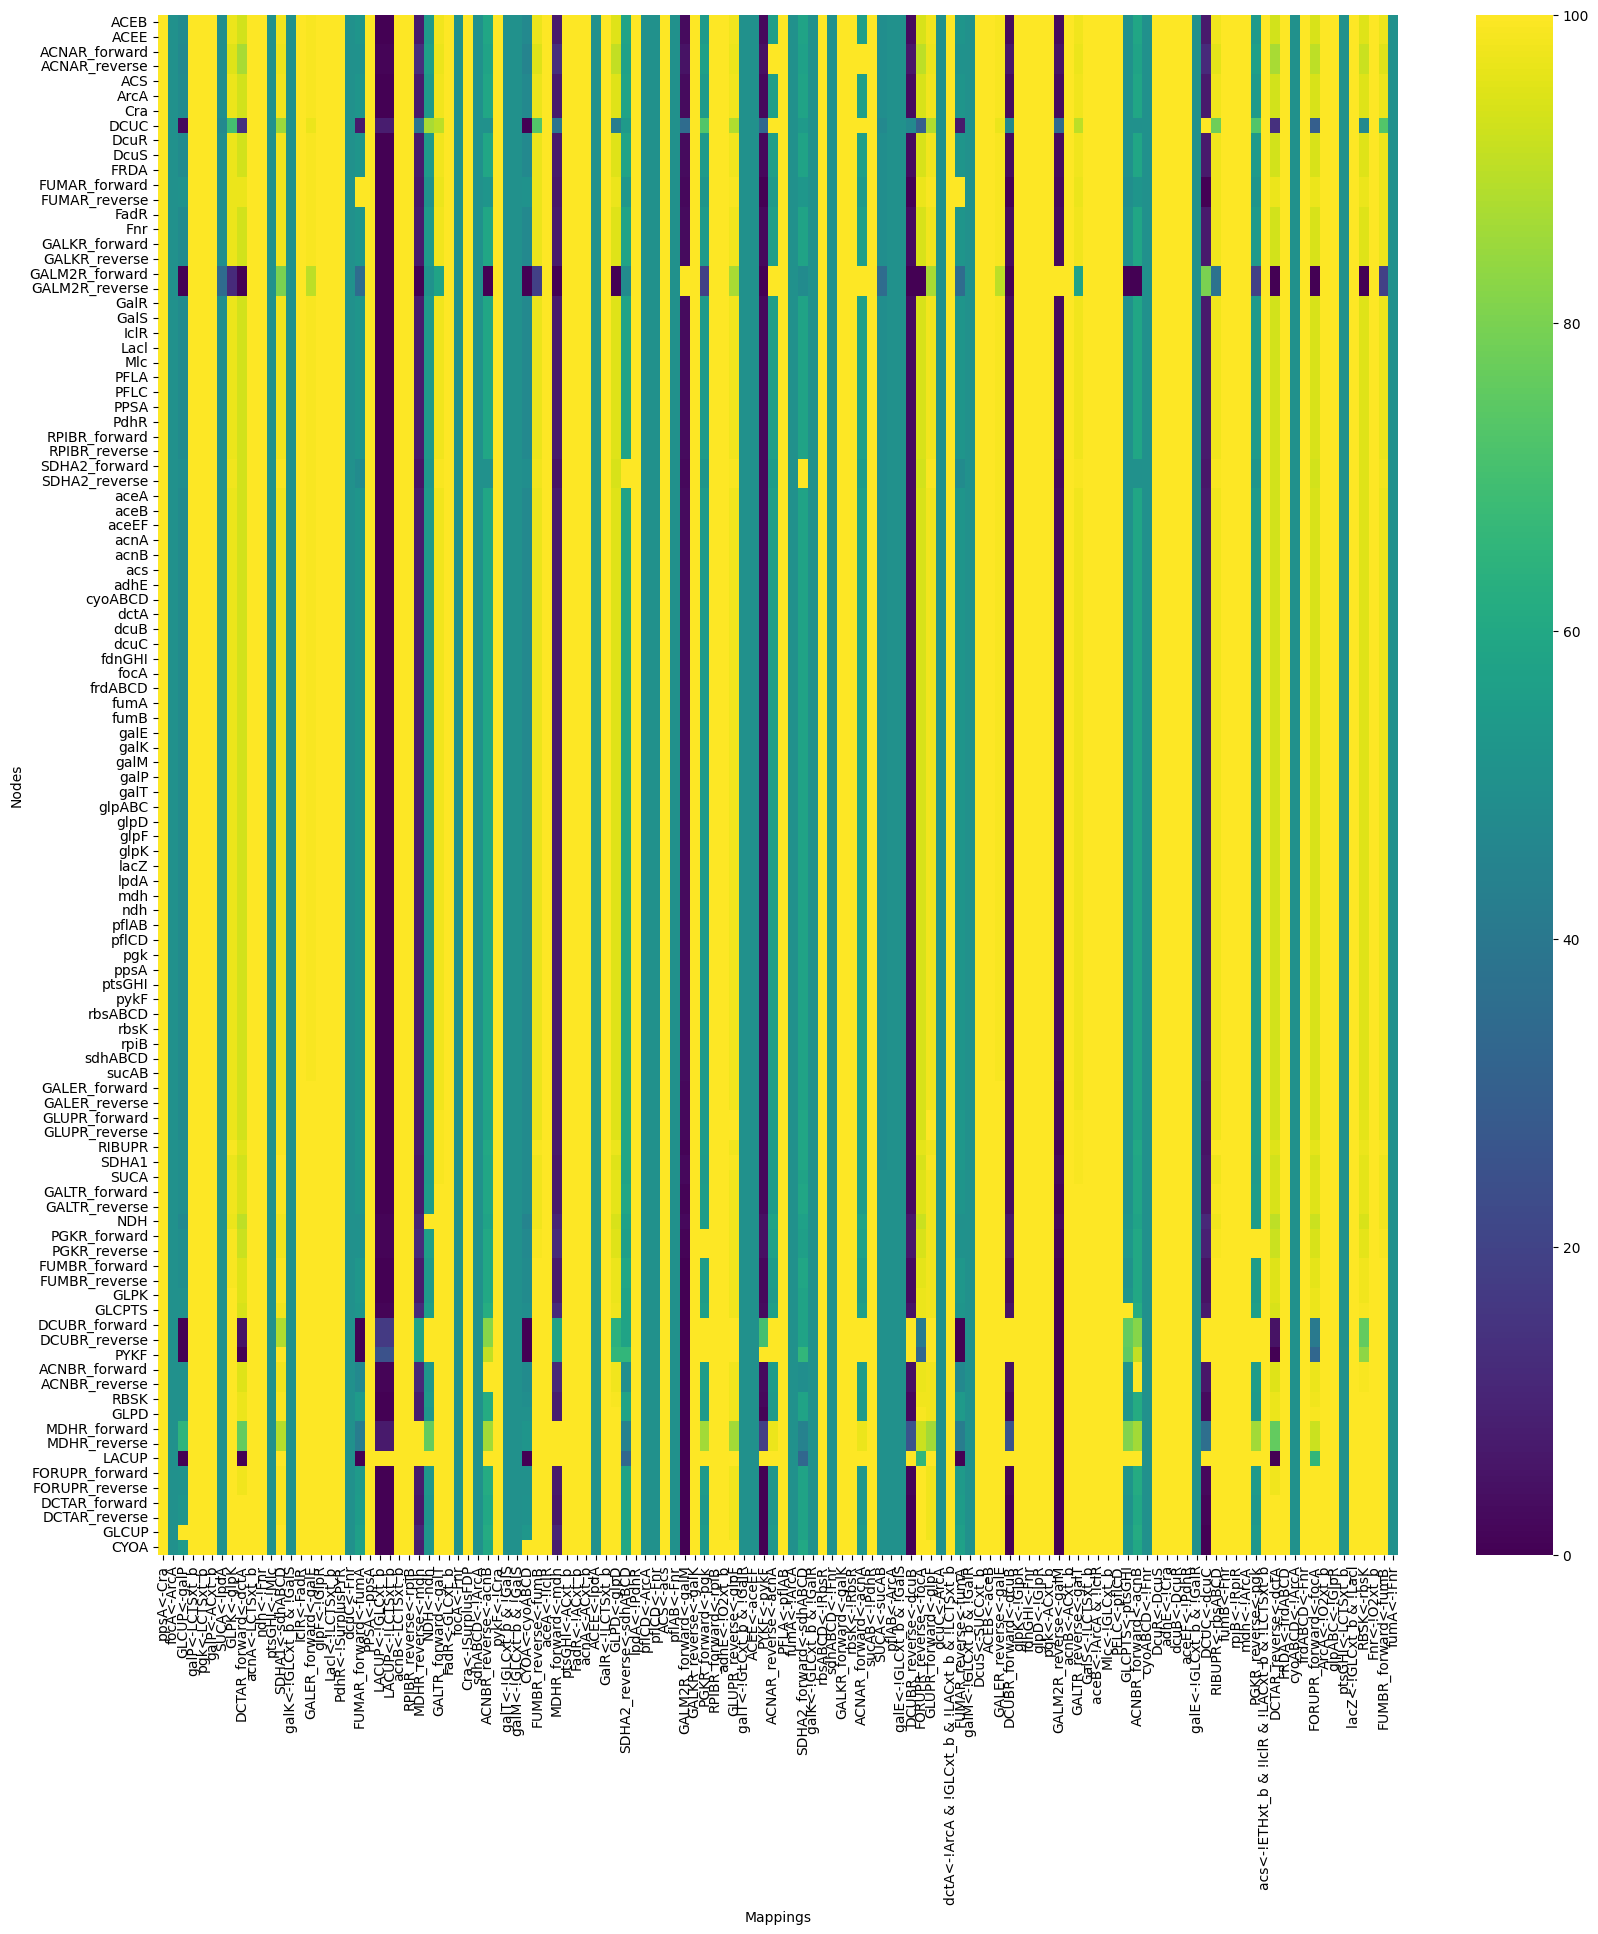

In [183]:
plt.figure(figsize=(20,20))
node_hp_all = sns.heatmap(node_vs_node_matrix_df,cmap = "viridis",  xticklabels=True, yticklabels=True, vmin=0)
node_hp_all.set(xlabel="Mappings",ylabel="Nodes")

### Remove the omnipresent mappings

In [184]:
def remove_omni_for_map_for_node(matrix: DataFrame, every_mapping_set: Dict[str, Set[str]], all_mappings: Set[str]) -> DataFrame:
    l_ubiq: List[str] = []
    tot_sol: int = len(every_mapping_set)
    for mapping in all_mappings:
        count = 0
        for solution in every_mapping_set: 
            if mapping in every_mapping_set[solution]:
                count += 1
        if count == tot_sol:
            l_ubiq.append(mapping)
    print("Number of mappings omnipresent: " + str(len(l_ubiq)))
    print("Total number of mappings: "+ str(len(all_mappings)))
    new_matrix = matrix.drop(columns = [m for m in l_ubiq])
    return new_matrix

In [185]:
simple_node_df = remove_omni_for_map_for_node(node_vs_node_matrix_df, every_mapping_set = every_mapping_set, all_mappings = all_mappings)

simple_node_df = simple_node_df.fillna(0)

node_matrix_simple_filename: str = f'{out_dir}/node_matrix_simple.csv'
simple_node_df.to_csv(node_matrix_simple_filename, sep=',')  

83
126


### Bi clustering heatmap

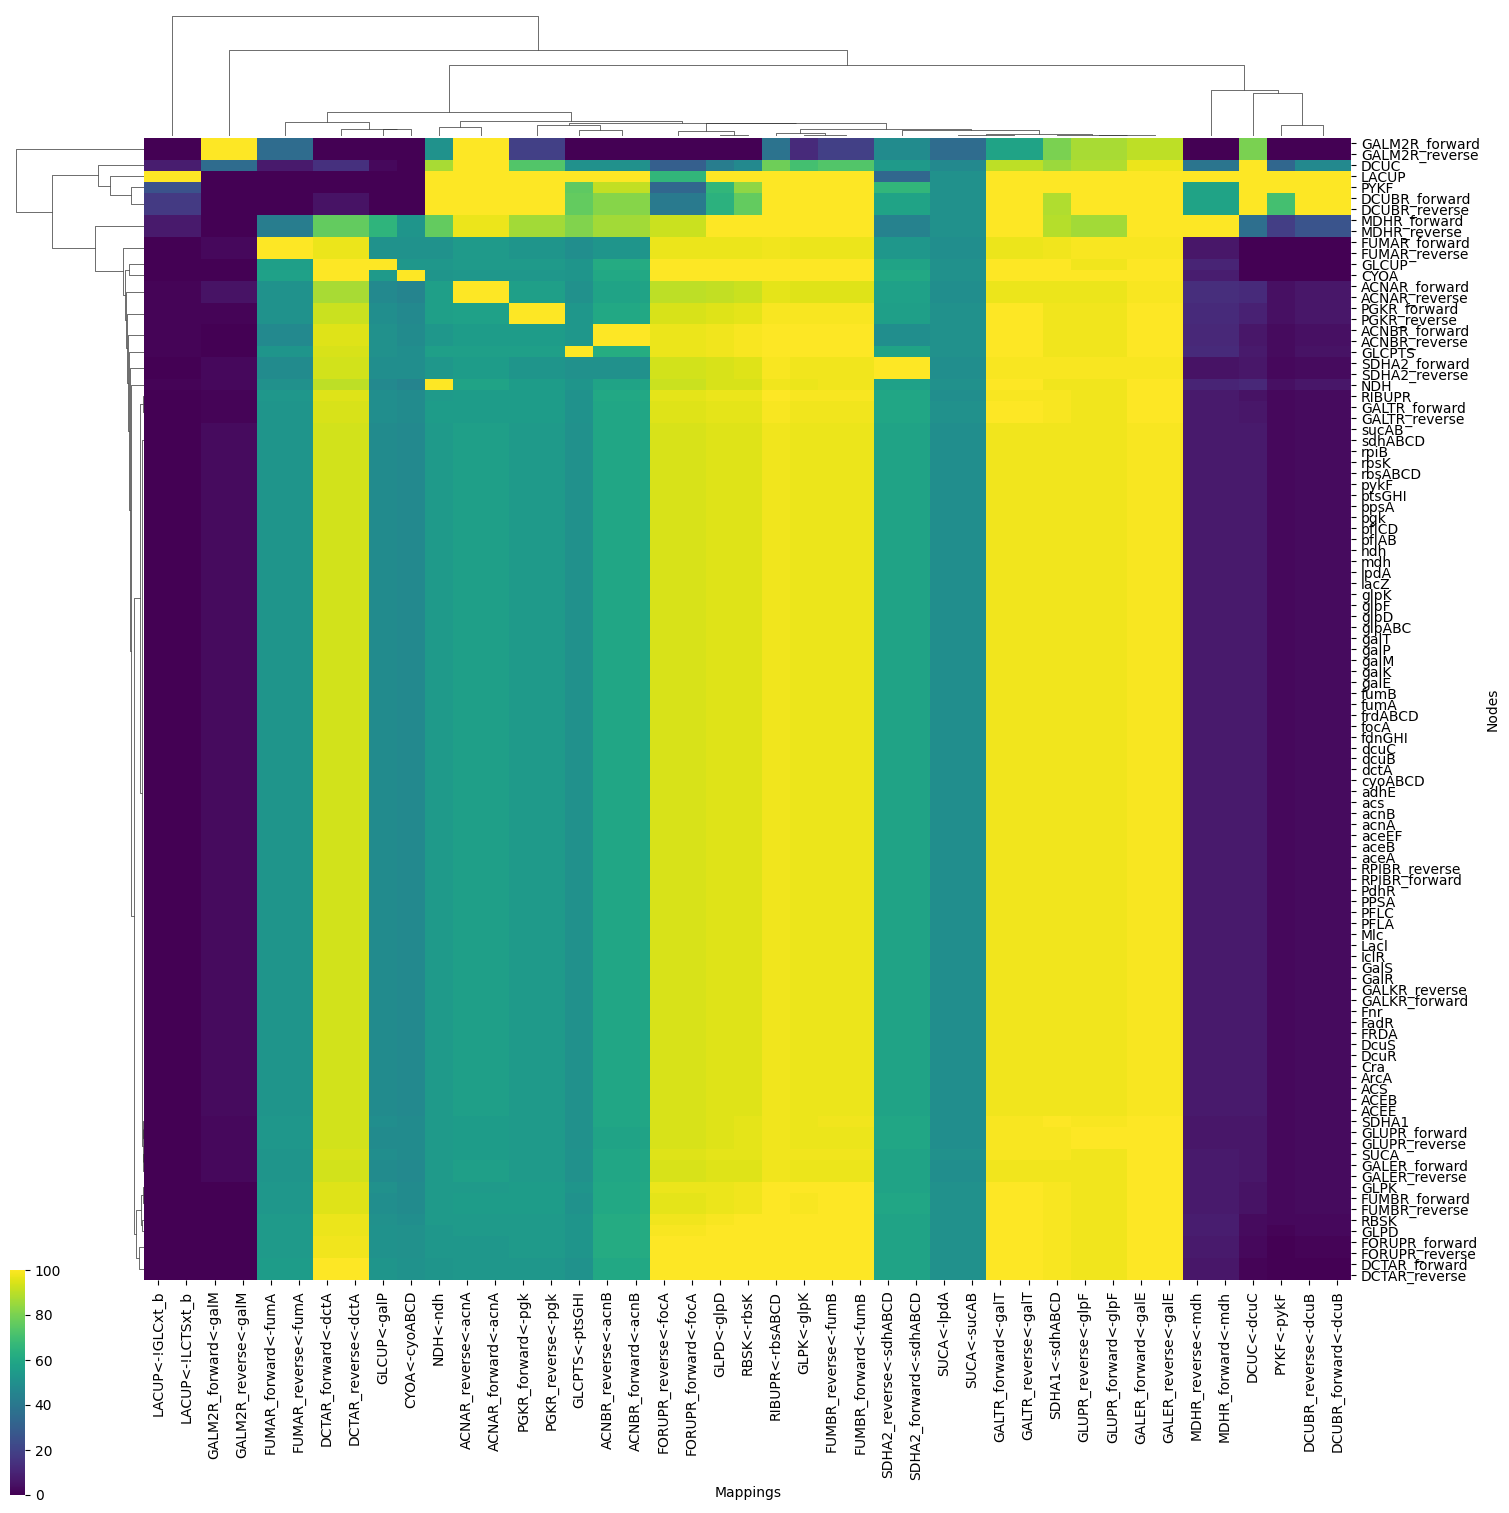

In [186]:
if len(simple_node_df.columns) == 0:
    print("Empty matrix")
elif len(simple_node_df.columns) == 1 :
    print("Error: only one mapping")

else:
    bchp_node = sns.clustermap(simple_node_df , figsize=(15,15), cmap="viridis", metric="jensenshannon" ,dendrogram_ratio = 0.1, cbar_pos = (0.01,0.0,0.01,0.15), xticklabels = True, yticklabels = True, vmin = 0, vmax = 100)
    node_ax = bchp_node.ax_heatmap
    node_ax.set_xlabel("Mappings")
    node_ax.set_ylabel("Nodes")
    bchp_node.savefig(f'{out_dir}/{instance_name}_nodeVSmapping.png',format='png')